   Author: Ankit Kariryaa, University of Bremen

### Getting started
Define the paths to the dataset and trained models in the `notebooks/config/UNetTraining.py` file.  

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import rasterio
import imgaug as ia
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import imageio
import os
import time
import rasterio.warp             # Reproect raster samples
from functools import reduce
from tensorflow.keras.models import load_model

from core.UNet import UNet
from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info import FrameInfo
from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset
from core.visualize import display_images

import json
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(tf.__version__)
tf.config.list_physical_devices('GPU')
from configx import Preprocessing_prediction
config = Preprocessing_prediction.Configuration(folder="full_area3")


2022-09-23 21:44:21.499111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 21:44:21.571154: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-23 21:44:21.590451: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-23 21:44:21.987172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

2.10.0


2022-09-23 21:44:22.922502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 21:44:22.940076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 21:44:22.940188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# Define the model and compile it
OPTIMIZER = adaDelta
LOSS = tversky 

#Only for the name of the model in the very end
OPTIMIZER_NAME = 'AdaDelta'
LOSS_NAME = 'weightmap_tversky'
model_path = "/home/lenovo/code/TreeSeg/notebooks/saved_models/UNet/model.h5"
model = load_model(model_path, custom_objects={'tversky': LOSS, 'dice_coef': dice_coef, 'dice_loss':dice_loss, 'accuracy':accuracy , 'specificity': specificity, 'sensitivity':sensitivity}, compile=False)


2022-09-23 21:44:28.202767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 21:44:28.204421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 21:44:28.204555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 21:44:28.204612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

[[599.      598.57166 597.50604 ... 624.9581  622.83    622.     ]
 [600.2499  599.761   598.5428  ... 626.0833  623.9714  623.1478 ]
 [603.3792  602.7381  601.1365  ... 628.94855 626.88513 626.0806 ]
 ...
 [584.82654 584.1055  582.25684 ... 562.51117 559.39923 558.192  ]
 [588.5116  587.61365 585.3056  ... 555.5228  552.7089  551.6315 ]
 [590.      589.0314  586.53986 ... 552.7357  550.0299  549.     ]]
1/1 [==============================] - 0s 14ms/step
(1, 256, 256, 1)
shape:  (1, 256, 256, 3)


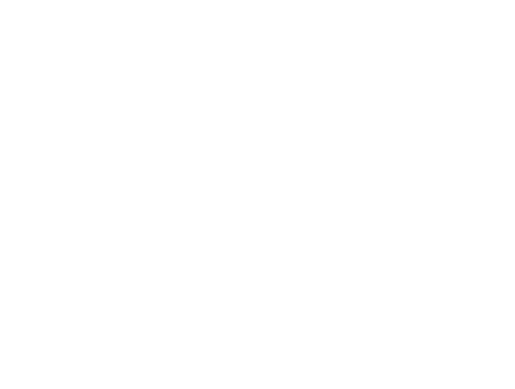

In [5]:
#write_dir="/media/lenovo/Elements SE/niyang_result_test/"
write_dir="/media/lenovo/Elements SE/niyang_result_png/"
resize_dataset_dir = "/media/lenovo/palsar(部分压缩包)/resize_test/"

for fn in range(0,1):
    for idx in range(1,2):
        ndvi_img= np.load(resize_dataset_dir+f"{fn}_{idx}_ndvi.npy")
        pan_img = np.load(resize_dataset_dir+f"{fn}_{idx}_pan.npy")
        # print(ndvi_img)
        print(pan_img)
        comb_img = np.stack((ndvi_img, pan_img), axis=0)
        comb_img = np.transpose(comb_img, axes=(1,2,0)) #Channel at the end
        comb_img = comb_img[np.newaxis,:]
        prediction = model.predict(comb_img, steps=1)
        prediction[prediction>0.5]=1
        prediction[prediction<=0.5]=0
        
        p=np.concatenate((comb_img , prediction), axis = -1)
        print(prediction.shape)
        display_images(p,titles=None, cmap=fn, norm=idx, interpolation=None, save=True, dir=write_dir)





1/1 [==============================] - 0s 10ms/step
(1, 256, 256, 1)
shape:  (1, 256, 256, 3)


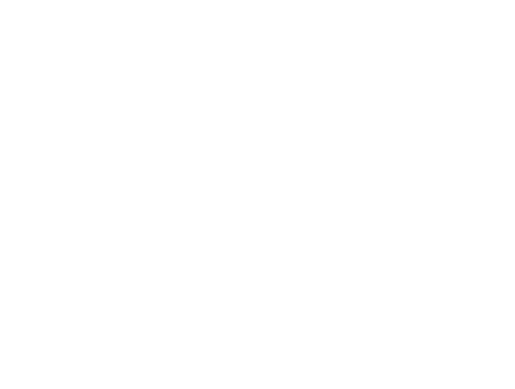

In [ ]:
fn=0
idx=1
ndvi_img= np.load(resize_dataset_dir+f"{fn}_{idx}_ndvi.npy")
pan_img = np.load(resize_dataset_dir+f"{fn}_{idx}_pan.npy")
comb_img = np.stack((ndvi_img, pan_img), axis=0)
comb_img = np.transpose(comb_img, axes=(1,2,0)) #Channel at the end
comb_img = comb_img[np.newaxis,:]
prediction = model.predict(comb_img, steps=1)
prediction[prediction>0.5]=1
prediction[prediction<=0.5]=0
print(prediction.shape)
p=np.concatenate((comb_img , prediction), axis = -1)
#titless=f"{fn}_{idx}"
display_images(p,titles=None, cmap=fn, norm=idx, interpolation=None, save=True, dir=write_dir)


[-0.5791353  -0.5791     -0.5790647  -0.57902944 -0.57899415 -0.5789588
 -0.5789235  -0.57888824 -0.57885295 -0.57881767 -0.5787823  -0.57874703
 -0.57871175 -0.57867646 -0.5786412  -0.57860583 -0.57857054 -0.57853526
 -0.5785     -0.5784647  -0.57842934 -0.57839406 -0.57835877 -0.5783235
 -0.5782882  -0.57825285 -0.57821757 -0.5781823  -0.578147   -0.5781117
 -0.57807636 -0.5780411  -0.5780058  -0.5779705  -0.5779352  -0.5778999
 -0.5778646  -0.5778293  -0.577794   -0.5777587  -0.57772344 -0.5776881
 -0.5776528  -0.5776175  -0.57758224 -0.57754695 -0.5775116  -0.5774763
 -0.57744104 -0.57740575 -0.57737046 -0.5773351  -0.57729983 -0.57726455
 -0.57722926 -0.577194   -0.57715863 -0.57712334 -0.57708806 -0.5770528
 -0.5770175  -0.57698214 -0.57694685 -0.57691157 -0.5768763  -0.576841
 -0.57680565 -0.57677037 -0.5767351  -0.5766998  -0.5766645  -0.57662916
 -0.5765939  -0.5765586  -0.5765233  -0.576488   -0.5764527  -0.5764174
 -0.5763821  -0.5763468  -0.5763115  -0.5762762  -0.5762409  

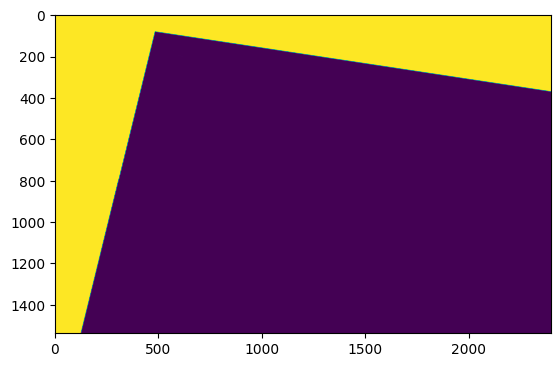

In [12]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np

def image_normalize(im, axis = (0,1), c = 1e-8):
    '''
    Normalize to zero mean and unit standard deviation along the given axis'''
    return (im - im.mean(axis)) / (im.std(axis) + c)

img = rasterio.open("/home/winter/code-resources/treeseg/test/interm_png/annotation-0-area0.png").read(1)
print(np.unique(img))
plt.imshow(img)
plt.show()